In [289]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    save_results,
    load_results,
    Policy
)

from ema_workbench.analysis import prim
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation

## Multi-Scenario MORDM
In the following Jupyter notebook, we walk through the process of multi-scenario MORDM. We do this to test optimal policies that comply with our own goals and result in favorouble policy outcomes. We start the process by following steps, outlined and explained at each step. Running this code takes a long time, therefore we have saved our runs in the archives folder. For ease of running we comment out the runs and only run the part where the archives are loaded.

### Step 1: Problem formulation
We start with problem formulation. We call up our functions and determine the reference values with which we will start optimizing.


In [290]:
ema_logging.log_to_stderr(ema_logging.INFO)

model, steps = get_model_for_problem_formulation(2)

reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "discount rate 3": 3.5,
        "ID flood wave shape": 4,
    }

scen1 = {}

for key in model.uncertainties:
    name_split = key.name.split("_")
    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})
    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

In [291]:
# to use for easy filtering of data

levers_ = [l.name for l in model.levers]
outcomes_ = [o.name for o in model.outcomes]
uncertainties_ = [u.name for u in model.uncertainties]

In [292]:
# list_results = []
# list_convergences = []

# with MultiprocessingEvaluator(model) as evaluator:
#     # run for 4 seeds
#     for i in range(4):
#         convergence_metrics = [EpsilonProgress(),]
#
#         with MultiprocessingEvaluator(model) as evaluator:
#             result, convergence = evaluator.optimize(
#                     nfe=40000,
#                     searchover="levers",
#                     epsilons=[0.01,]*len(model.outcomes),
#                     convergence=convergence_metrics,
#                     reference=ref_scenario,
#                 )
#         list_results.append(result)
#         list_convergences.append(convergence)
#
# with open("./archives/step1_results", "wb") as fp:
#     pickle.dump(list_results, fp)
# with open("./archives/step1_convergences","wb") as fp:
#     pickle.dump(list_convergences,fp)

In [316]:
# This code loads our saved lists with the results and convergences for all 4 seeds

with open("./archives/step1_results", "rb") as fp:   # Unpickling
    list_results = pickle.load(fp)

with open("./archives/step1_convergences", "rb") as fp:   # Unpickling
    list_convergences = pickle.load(fp)

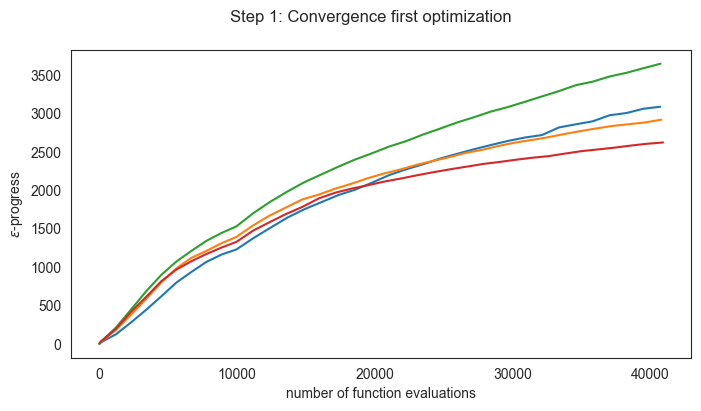

In [317]:
fig, ax = plt.subplots(figsize=(8,4))
for i in range(4):
    ax.plot(list_convergences[i].nfe, list_convergences[i].epsilon_progress)
    ax.set_ylabel('$\epsilon$-progress')
    ax.set_xlabel('number of function evaluations')
plt.suptitle('Step 1: Convergence first optimization')
plt.show()

### Step 2: Searching for candidate solutions
The next step we will use the devised policies from the optimization to determine the best results. We concatinate all obtained results from the 4 seeds we ran, and we filter these based on criteria most relevant for our actor. This is summarized as:
* No room for river in locations 1 and 2
* Dike heightening of at least 0.3m in dike 1
* Average dike heightening across all dikes greater than 0.42 meters

In [318]:
def describe_policies(df):
    '''We use this function to describe the policies to be more interpretable. It shows where room for river has been implemented,
        Total increase of each dike and days to threat.'''
    descriptions = ['RfR 0', 'RfR 1', 'RfR 2', 'RfR 3', 'RfR 4','Dike 1','Dike 2','Dike 3', 'Dike 4', 'Dike 5','EWS_DaysToThreat']
    for desc in descriptions:
        if 'RfR' in desc:
            ring = int(desc[-1])
            df[desc] = df.loc[:, f'{ring}_RfR 0':f'{ring}_RfR 3'].sum(axis=1)
        if 'Dike' in desc:
            ring = int(desc[-1])
            df[desc] = df.loc[:, f'A.{ring}_DikeIncrease 0':f'A.{ring}_DikeIncrease 0'].sum(axis=1)

    df.index.names = ['Policy']

    return df[descriptions]

In [319]:
results = pd.concat(list_results)

In [320]:
results['room for river 1 & 2'] = results.loc[:, '0_RfR 0':'1_RfR 3'].sum(axis=1)
results['dike heightening 1'] = results.loc[:, 'A.1_DikeIncrease 0':'A.1_DikeIncrease 3'].sum(axis=1)
results['average heightening'] = results.loc[:, 'A.1_DikeIncrease 0':'A.4_DikeIncrease 3'].sum(axis=1) / 5

In [321]:
selection = results[results['room for river 1 & 2'] == 0]
selection = selection[selection['dike heightening 1'] >= 3]
final_selection = selection[selection['average heightening'] > 4.2]

In [322]:
policies = final_selection.loc[:, levers_]

In [323]:
describe_policies(policies)

,RfR 0,RfR 1,RfR 2,RfR 3,RfR 4,Dike 1,Dike 2,Dike 3,Dike 4,Dike 5,EWS_DaysToThreat
Policy,,,,,,,,,,,
58,0,0,1,0,0,3,3,5,6,7,0
394,0,0,0,0,0,3,4,5,7,7,0
8,0,0,0,0,0,3,7,4,0,7,0
145,0,0,0,0,0,3,4,4,7,7,0
340,0,0,0,0,0,3,4,7,0,6,2
71,0,0,0,0,0,3,6,4,3,5,0


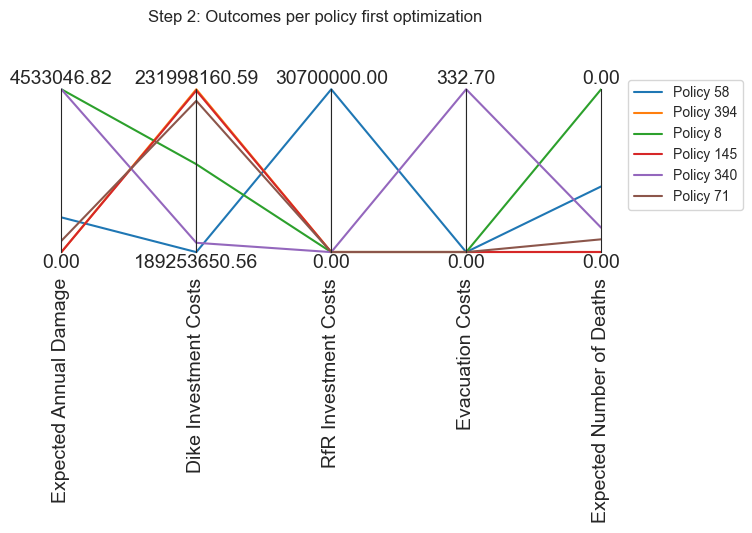

In [324]:
data = final_selection.loc[:, outcomes_]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.legend([f'Policy {i}' for i in data.index], bbox_to_anchor=(2.1,1))
plt.suptitle(x=0.5,y=1.1,t='Step 2: Outcomes per policy first optimization')
plt.show()

In [325]:
print(f'We continue with {len(policies)} policies.')

We continue with 6 policies.


### Step 3: Re-evaluate candidate solutions under uncertainty
With these 6 obtained policies, we move on to the next step, performing experiments. We take the 6 policies and test them in 1000 scenarios. We then use the results to test the robustness.

In [326]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [327]:
# n_scenarios = 1000
# with MultiprocessingEvaluator(model) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)
# save_results(results, "./archives/step3_results.tar.gz")

In [328]:
results = load_results('./archives/step3_results.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/emmavankleef/Documents/Master/Jaar_2/Periode_4/EPA1361_Final_Group4/archives/step3_results.tar.gz


#### Robustness metrics
We use two robustness metrics to test the 6 given policies.

**Signal to noise**

In [329]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [330]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

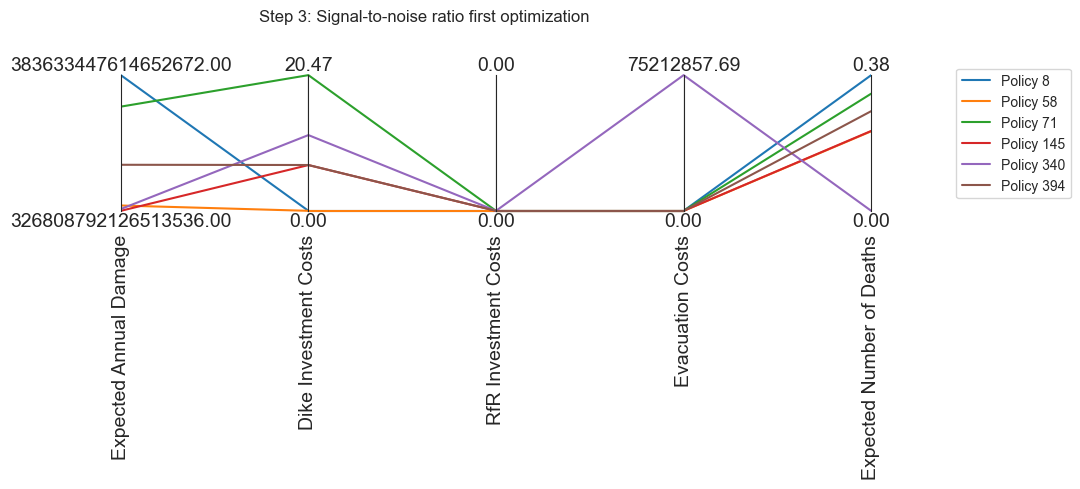

In [331]:
data = scores
limits = parcoords.get_limits(data)
labels = data.index

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
fig = plt.gcf()
fig.set_size_inches((10, 4))
plt.legend([f'Policy {i}' for i in data.index], bbox_to_anchor=(2.1,1))
plt.suptitle(x=0.5,y=1.1,t='Step 3: Signal-to-noise ratio first optimization')
plt.show()

**Max regret**

In [332]:
experiments, outcomes = results

outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    # as all our data needs to be minimized, max regret is calculated as value - best,
    # best being the minimum value in the list.
    best = x.min(numeric_only=True)
    regret = x.loc[:, best.index] - best
    regret['policy'] = x.policy
    return regret

regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

max_regret = regret.groupby('policy').max().drop('scenario',axis=1)

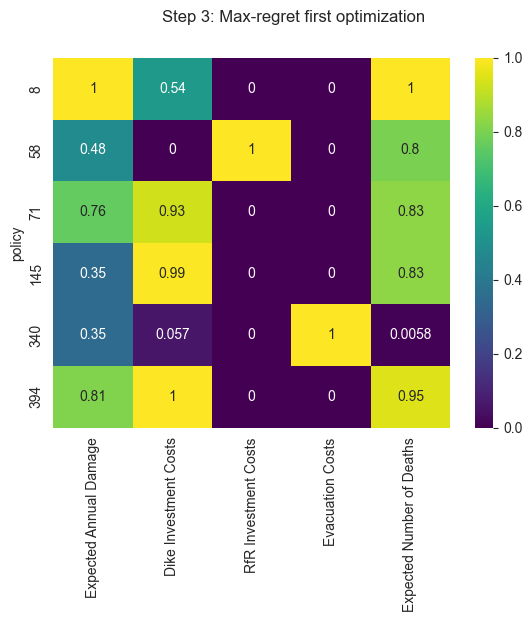

In [333]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.suptitle('Step 3: Max-regret first optimization')
plt.show()

### Step 4: Scenario discovery
In this step we use PRIM to determine which scenarios are most interesting to explore. We choose a set of scenarios that has a high density and coverage to then look at which are best and which are worst. The chosen scenarios will then be used for the next step.

In [334]:
x = experiments.iloc[:, :-3]
y = outcomes['Expected Annual Damage'] < np.percentile(outcomes['Expected Annual Damage'],10)

prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.1)
box = prim_alg.find_box()

[MainProcess/INFO] 6000 points remaining, containing 600 cases of interest
[MainProcess/INFO] mean: 0.9290123456790124, mass: 0.054, coverage: 0.5016666666666667, density: 0.9290123456790124 restricted_dimensions: 6


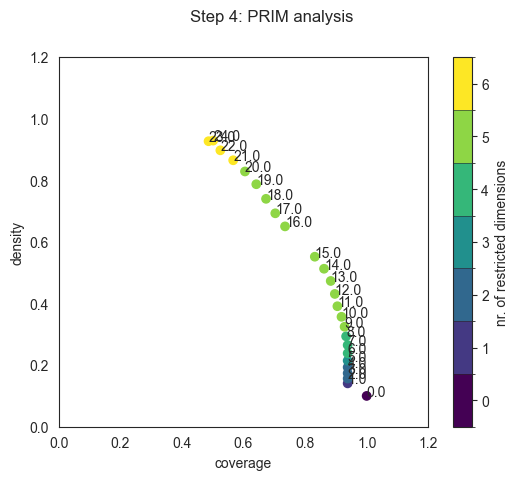

In [335]:
box.show_tradeoff(annotated=True)
plt.suptitle('Step 4: PRIM analysis')
plt.show()

In [336]:
box.inspect(16)

coverage     0.735000
density      0.650442
id          16.000000
mass         0.113000
mean         0.650442
res_dim      5.000000
Name: 16, dtype: float64

                      box 16                                 
                         min       max      qp value qp value
A.2_pfail           0.457046  0.999505  3.452539e-52      NaN
A.4_DikeIncrease 0  6.000000  7.000000  2.407409e-44      NaN
A.3_pfail           0.347285  0.999667  8.784380e-30      NaN
A.1_pfail           0.270826  0.999697  5.182521e-24      NaN
A.5_pfail           0.115017  0.999616  4.379391e-04      NaN



[None]

In [337]:
box.select(16)

box_scenarios = experiments.iloc[box.yi]
box_outcomes = {k:v[box.yi] for k,v in outcomes.items()}

We select box 16 as it has a balanced value for coverage and density, and use this box to determining **best and worst case** scenarios to explore.

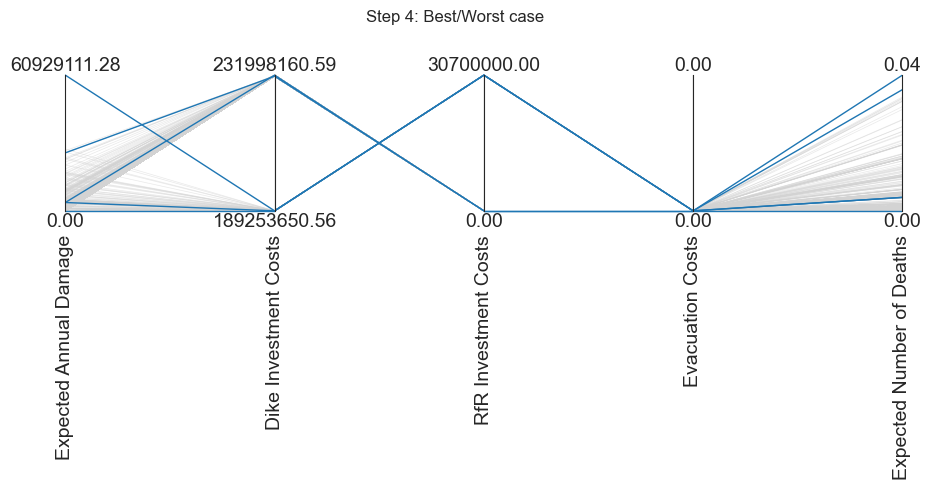

In [338]:
# conditional on y
all_data = pd.DataFrame(box_outcomes)[outcomes_]

# let's get the unique indices for the minima and maxima across
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.loc[indices], color=sns.color_palette()[0], lw=1)

fig = plt.gcf()
fig.set_size_inches((10, 4))
plt.suptitle(x=0.5,y=1.1,t='Step 4: Best/Worst case')
plt.show()

In [339]:
print(all_data.idxmax())
print(all_data.idxmin())

Expected Annual Damage        137
Dike Investment Costs        1001
RfR Investment Costs            1
Evacuation Costs                1
Expected Number of Deaths    3546
dtype: int64
Expected Annual Damage          2
Dike Investment Costs           1
RfR Investment Costs         1001
Evacuation Costs                1
Expected Number of Deaths       2
dtype: int64


In [340]:
chosen_scenarios = [137,3546,2]

In [341]:
selected = experiments.loc[chosen_scenarios]

In [342]:
outcomes.iloc[chosen_scenarios]

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,scenario,policy
137,6.092911e+07,1.892537e+08,30700000.0,0.0,0.033856,1137,58
3546,2.603281e+07,2.316651e+08,0.0,0.0,0.037899,1546,145
2,0.000000e+00,1.892537e+08,30700000.0,0.0,0.000000,1002,58


In [343]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

Using the best and worst case we end up with 3 scenarios that are interesting for re-optimization, as 1 and 1001 repeat in both and are therefore not interesting to explore.

### Step 5: Re-optimization with newfound scenarios
We use the above three scenarios and run the optimization for 2 seeds each, resulting in 6 runs.


In [344]:
def run_scenario(scenario):
    list_results = []
    list_convergences = []
    for i in range(2):
        convergence_metrics = [EpsilonProgress()]
        with MultiprocessingEvaluator(model) as evaluator:
            result, convergence = evaluator.optimize(
                    nfe=40000,
                    searchover="levers",
                    epsilons=[0.01,]*len(model.outcomes),
                    convergence=convergence_metrics,
                    reference=scenario,
                )
        list_results.append(result)
        list_convergences.append(convergence)

    return pd.concat(list_results), list_convergences

# list_of_results = []
# for scenario in scenarios:
#     list_of_results.append(run_scenario(scenario))
#
# with open("./archives/step5_results", "wb") as fp:
#     pickle.dump(list_of_results, fp)

In [345]:
# We use pickle again to load the list from the archives

with open("./archives/step5_results", "rb") as fp:   # Unpickling
    list_of_results = pickle.load(fp)

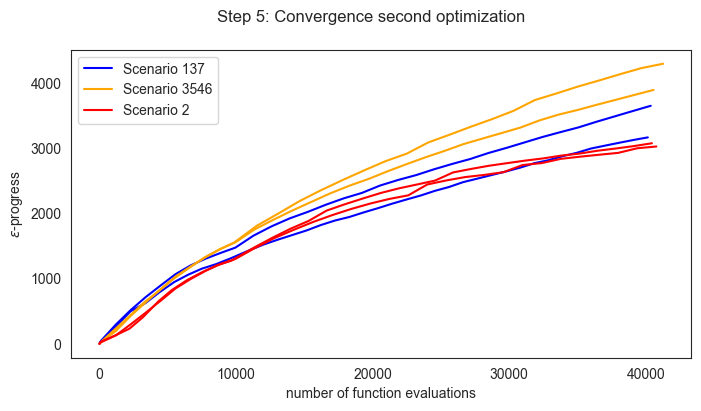

In [346]:
colors = ['blue','orange','red']
fig, ax = plt.subplots(figsize=(8,4))
for i in range(3):
    ax.plot(list_of_results[i][1][0].nfe, list_of_results[i][1][0].epsilon_progress,
            color=colors[i])
    ax.plot(list_of_results[i][1][1].nfe, list_of_results[i][1][1].epsilon_progress,
            label=f"Scenario {chosen_scenarios[i]}", color=colors[i])
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.suptitle('Step 5: Convergence second optimization')
ax.legend()
plt.show()

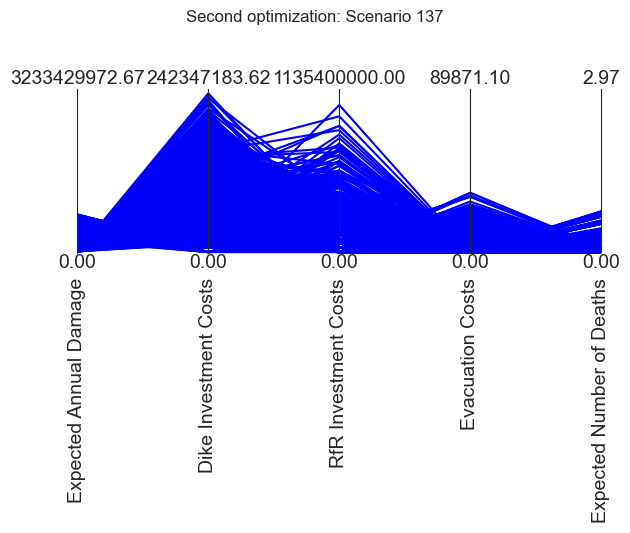

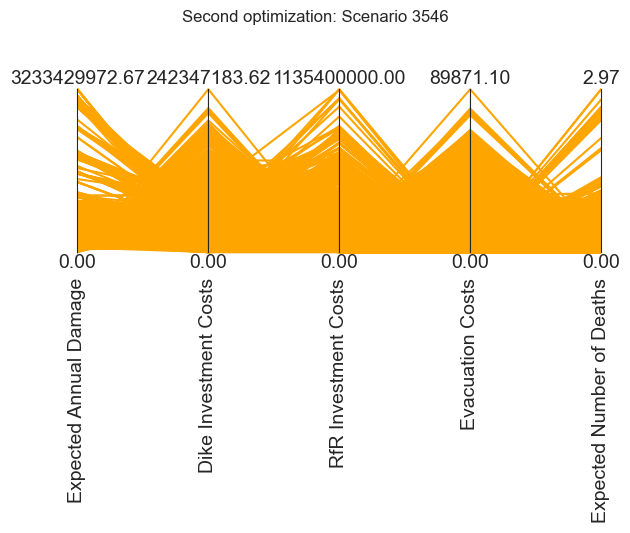

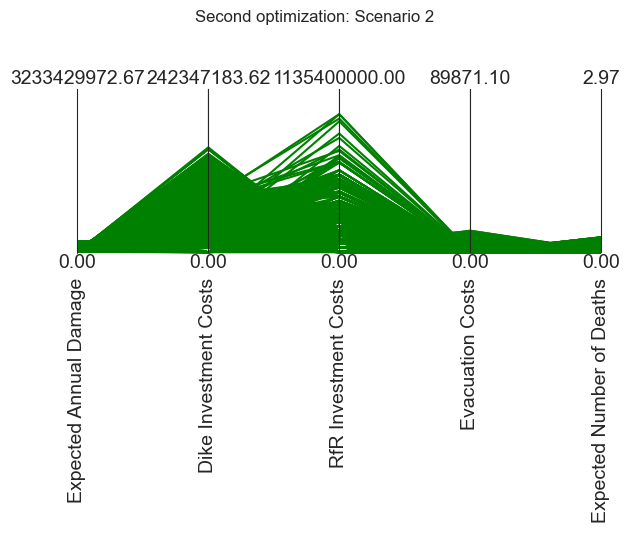

In [347]:
colors = ['blue','orange','green']
limits = parcoords.get_limits(pd.concat([list_of_results[i][0].iloc[:, -5:] for i in range(3)]))

for i in range(3):
    data = list_of_results[i][0].iloc[:, -5:]

    paraxes = parcoords.ParallelAxes(limits)
    paraxes.plot(data,color=colors[i])
    plt.suptitle(x=0.5,y=1.1,t=f'Second optimization: Scenario {chosen_scenarios[i]}')
    plt.show()

### Step 6: Run experiments with new policies
We filter our policies once again on the same criteria (with an increase in criteria for average dike heightening, as there are better policies) as in step 2 and use these to run experiments.

In [348]:
results = pd.concat([results for results, _ in list_of_results])

In [349]:
results['room for river 1 & 2'] = results.loc[:, '0_RfR 0':'1_RfR 3'].sum(axis=1)
results['dike heightening 1'] = results.loc[:, 'A.1_DikeIncrease 0':'A.1_DikeIncrease 3'].sum(axis=1)
results['average heightening'] = results.loc[:, 'A.1_DikeIncrease 0':'A.4_DikeIncrease 3'].sum(axis=1) / 5

In [350]:
selection = results[results['room for river 1 & 2'] == 0]
selection = selection[selection['dike heightening 1'] >= 3]
final_selection = selection[selection['average heightening'] > 5]

In [351]:
policies = final_selection.loc[:, '0_RfR 0':'A.5_DikeIncrease 3']

In [352]:
describe_policies(policies)

,RfR 0,RfR 1,RfR 2,RfR 3,RfR 4,Dike 1,Dike 2,Dike 3,Dike 4,Dike 5,EWS_DaysToThreat
Policy,,,,,,,,,,,
744,0,0,0,0,0,3,3,5,10,5,3
13,0,0,0,2,0,3,3,4,10,6,0
391,0,0,1,0,0,3,6,4,10,6,0
609,0,0,1,1,0,3,3,7,10,7,1
122,0,0,0,0,0,3,4,6,6,9,3
2,0,0,0,0,0,3,3,6,5,9,0


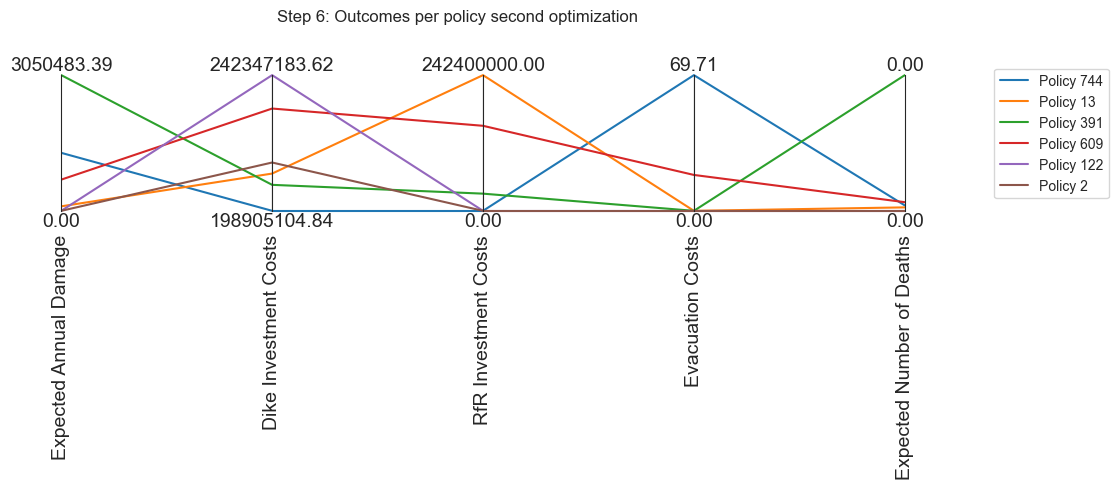

In [353]:
data = final_selection.loc[:, 'Expected Annual Damage':'Expected Number of Deaths']
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

fig = plt.gcf()
fig.set_size_inches((10, 4))
plt.suptitle(x=0.5,y=1.1,t='Step 6: Outcomes per policy second optimization')
plt.legend([f'Policy {i}' for i in data.index], bbox_to_anchor=(2,1))
plt.show()

In [354]:
print(f'We continue with {len(policies)} policies.')

We continue with 6 policies.


### Step 7: Re-evaluate candidate solutions under uncertainty
With these 6 obtained policies we perform experiments and test the robustness of the results.

In [355]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [356]:
# with MultiprocessingEvaluator(model) as evaluator:
#     reeevaluation_results = evaluator.perform_experiments(1000, policies=policies_to_evaluate)
#
# with open("./archives/step7_results", "wb") as fp:
#     pickle.dump(reeevaluation_results, fp)

In [357]:
# We use pickle again to load the list from the archives

with open("./archives/step7_results", "rb") as fp:   # Unpickling
    reeevaluation_results = pickle.load(fp)

##### Test robustness
Finally, we arrive at the last step, where we use the same two robustness metrics to determine how robust the new policies are.

**Signal-to-noise**

In [358]:
experiments, outcomes = reeevaluation_results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

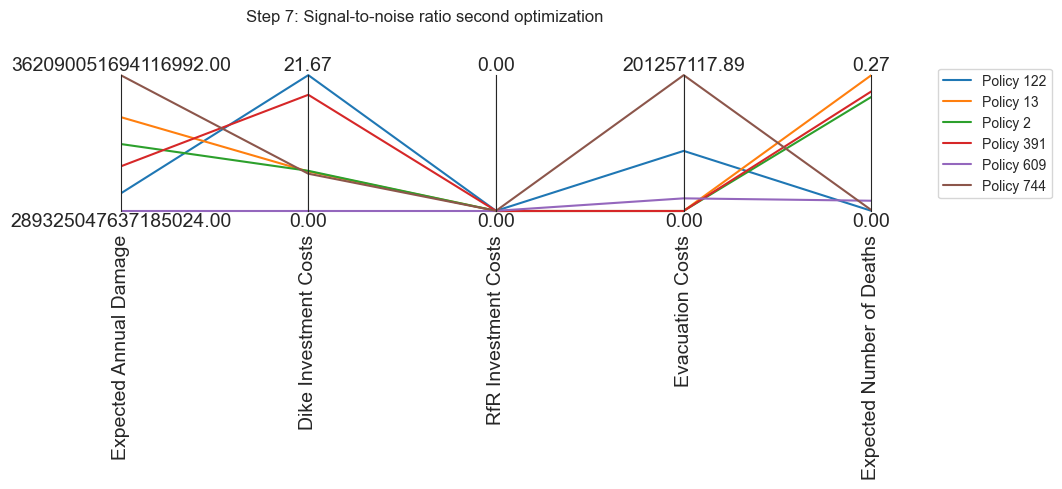

In [359]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

fig = plt.gcf()
fig.set_size_inches((10, 4))
plt.suptitle(x=0.5,y=1.1,t='Step 7: Signal-to-noise ratio second optimization')
plt.legend([f'Policy {i}' for i in data.index], bbox_to_anchor=(2,1))
plt.show()

**Max regret**

In [360]:
experiments, outcomes = reeevaluation_results

outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    best = x.min(numeric_only=True)
    regret = x.loc[:, best.index] - best
    regret['policy'] = x.policy
    return regret

regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

max_regret = regret.groupby('policy').max()

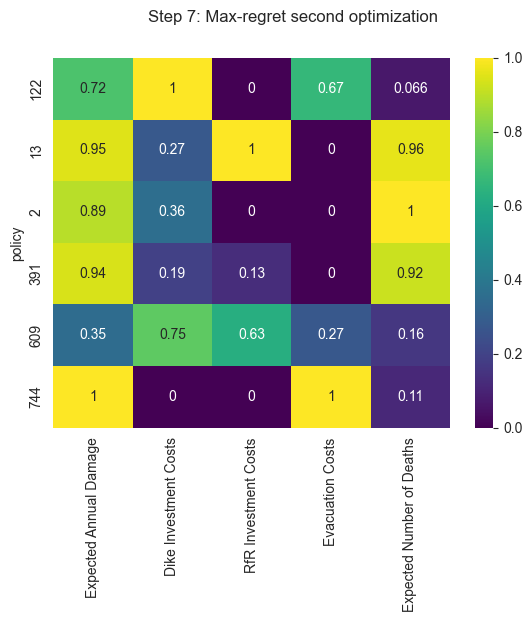

In [361]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.suptitle('Step 7: Max-regret second optimization')
plt.show()

### Step 8: Final scenario discovery
In the last stage we conduct another scenario discovery using the PRIM algorithm, focusing on the 20% highest values for annual damage. We use the results and chose a box to investigate.

In [362]:
x = experiments.iloc[:, :-3]
y = outcomes['Expected Annual Damage'] > np.percentile(outcomes['Expected Annual Damage'],80)

prim_alg = prim.Prim(x, y, threshold=0.8)
box2 = prim_alg.find_box()

[MainProcess/INFO] 6000 points remaining, containing 1197 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.121, coverage: 0.606516290726817, density: 1.0 restricted_dimensions: 3


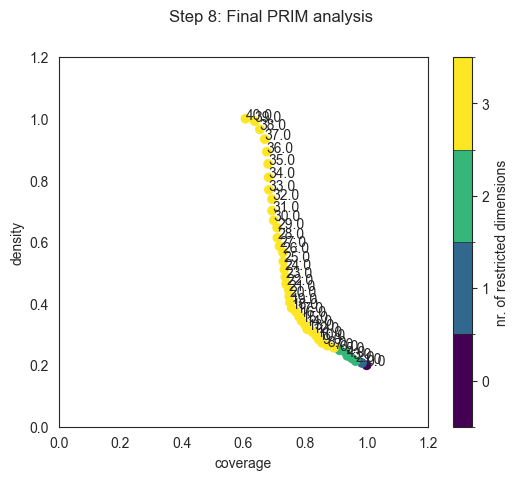

In [363]:
box2.show_tradeoff(annotated=True)
plt.suptitle('Step 8: Final PRIM analysis')
plt.show()

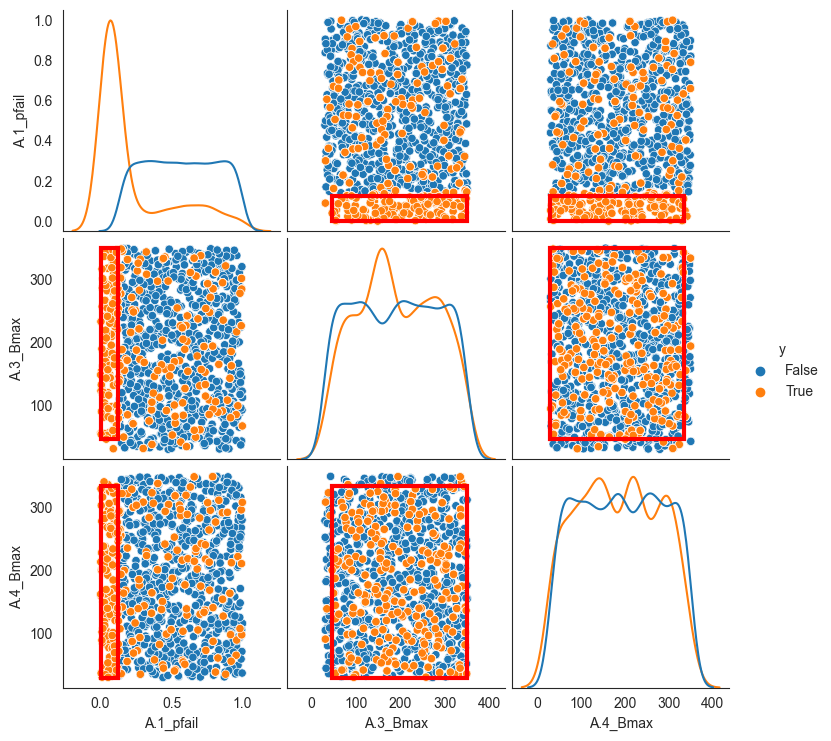

In [364]:
box2.show_pairs_scatter()
plt.show()

In [365]:
box2.inspect(26)

coverage     0.728488
density      0.565499
id          26.000000
mass         0.257000
mean         0.565499
res_dim      3.000000
Name: 26, dtype: float64

              box 26                                     
                 min         max  qp value       qp value
A.1_pfail   0.000592    0.277891       NaN  9.094403e-200
A.4_Bmax   30.258555  334.528027       NaN   8.395794e-02
A.3_Bmax   45.955506  349.947922  0.117353            NaN



[None]

In [366]:
box2.select(26)

box2_scenarios = experiments.iloc[box2.yi]
box2_outcomes = {k:v[box2.yi] for k,v in outcomes.items()}

In [367]:
box2_scenarios[uncertainties_].describe()

,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.2_Bmax,A.2_pfail,A.3_Bmax,A.3_pfail,A.4_Bmax,A.4_pfail,A.5_Bmax,A.5_pfail
count,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000,1542.000000
mean,64.330739,192.750744,0.134581,192.400277,0.499196,199.483817,0.502896,181.695079,0.516892,191.046997,0.473531
std,37.386708,92.875449,0.079684,92.505729,0.287773,85.420585,0.272602,88.045740,0.285403,94.958742,0.280680
min,0.000000,31.017019,0.000592,30.191353,0.000734,46.210303,0.001847,30.552505,0.001189,30.288658,0.003834
25%,31.000000,112.411461,0.066770,111.881129,0.242394,133.464953,0.295105,104.351306,0.271493,104.244696,0.256166
50%,64.000000,198.531856,0.131007,193.855323,0.499044,195.656162,0.517860,172.637698,0.528780,189.871347,0.454855
75%,96.000000,270.493698,0.200089,267.114554,0.740214,271.592832,0.719952,255.879462,0.761608,269.706218,0.692700
max,132.000000,348.978713,0.277219,349.456712,0.999572,349.947922,0.996011,334.387447,0.997221,349.271637,0.991573


---------
Final results were the following policies:

In [368]:
final_policies = experiments[['policy'] + levers_].groupby('policy').mean(numeric_only=True)

In [369]:
describe_policies(final_policies)

,RfR 0,RfR 1,RfR 2,RfR 3,RfR 4,Dike 1,Dike 2,Dike 3,Dike 4,Dike 5,EWS_DaysToThreat
Policy,,,,,,,,,,,
122,0.0,0.0,0.0,0.0,0.0,3.0,4.0,6.0,6.0,9.0,3.0
13,0.0,0.0,0.0,2.0,0.0,3.0,3.0,4.0,10.0,6.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3.0,3.0,6.0,5.0,9.0,0.0
391,0.0,0.0,1.0,0.0,0.0,3.0,6.0,4.0,10.0,6.0,0.0
609,0.0,0.0,1.0,1.0,0.0,3.0,3.0,7.0,10.0,7.0,1.0
744,0.0,0.0,0.0,0.0,0.0,3.0,3.0,5.0,10.0,5.0,3.0


-- End of File --